In [1]:
import gym
import gym_sokoban
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from IPython import display

import queue
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import warnings
warnings.filterwarnings('ignore')
import os
if not os.path.exists("model"):
    os.mkdir("model")





# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

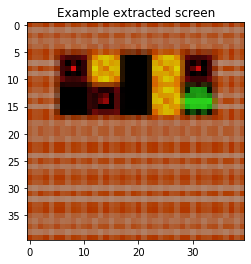

In [2]:
env = gym.make('Sokoban-small-v1')
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])
def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


# Get screen size so that we can initialize layers correctly based on shape
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [89]:
class NN(nn.Module):

    def __init__(self, h, w):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        #self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        #self.bn3 = nn.BatchNorm2d(32)
       
    
        
        

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        #def conv2d_size_out(size, kernel_size = 3, stride = 1):
         #   return (size - (kernel_size - 1) - 1) // stride  + 1
        #convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        #convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        #linear_input_size = convw * convh * 32
        
        
        self.fc1 = nn.Linear(3*3*32, 3*3*32)
        
        self.fc21 = nn.Linear(3*3*32, 1)
        
        self.fc22_1 = nn.Linear(3*3*32, 8)
        self.fc22_2 = nn.Softmax()

    
        
       
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x, val_bool = False):
        
        x = F.relu(self.bn1(self.conv1(torch.FloatTensor(np.asarray(x.reshape(1, 1, 7 , 7))))))
        
        x = F.relu(self.bn2(self.conv2(x)))
        #print(x.size())
        #x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        if val_bool == True:
            return self.fc21(x.view(x.size(0), -1))
        else:
            x = F.relu(self.fc22_1(x.view(x.size(0), -1)))
            return self.fc22_2(x.view(x.size(0), -1))
        


[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.016592975705862045
-0.01659297

KeyboardInterrupt: 

In [ ]:
def train_model(t_max, main_model, global_t):

    thread = gym.make('Sokoban-small-v1') 


    # sync train model copy with global train model
    #train_model = main_model


    # thread-step-counter t = 0
    t = 0


    #pol_netlist[counter] = net

    # reset policy and val gradients
    optimizer.zero_grad() 

    # tstart = t
    # get state s_t
    thread.reset()

    r = []
    s = []
    a = []

    # while t < t_max and game_not_finished
    game_finished = False
    
    #print(type(torch.from_numpy(thread.render('tiny_rgb_array'))))
    
    while t < t_max and not game_finished:

        # perform a_t with policy net
        #print((torch.from_numpy(thread.render('tiny_rgb_array')[:,:,0])))
        s.append(torch.from_numpy(thread.render('tiny_rgb_array')[:,:,0]))
        print(main_model(s[t], val_bool = False).max(1)[1].item())
        a.append(main_model(s[t], val_bool = False).max(1)[1].view(1, 1).item())

        _, reward, game_finished,_ = thread.step(a[t]+1) # mapping actions + 1 

        r.append(reward)

        


    # R = 0 if game_not_finished == True, else R = value(s_t)

    if (game_finished == True):
        R = 0
    else: 
        #print(train_model(s[t-1], val_bool = True))#.view(1, 1).item())
        R = main_model(s[t], val_bool = True).view(1, 1).item()
        
        t = t + 1
        
    for j in range(t-1, -1, -1):
        R = r[j] + gamma*R
        val = main_model(s[j], val_bool = True)
    
        # PROBLEM: FUNKTIONIERT DAS BACKPROP RICHTIG, wegen verschiedenen branches
        loss = numpy.log(main_model(s[j], val_bool = False).max()*(R-val))
        loss.backwards()
        optimizer.step()
        loss = np.square(val-R)
        loss.backwards()
        optimizer.step()

    # perform asynchronous updates of policy and value net using the gradients
    
    print("global training step", global_t, "finished")
            


In [100]:
def test_model(episodes):
    
    env = gym.make('Sokoban-small-v1')
    env.render('tiny_rgb_array')[:,:,0]
    
    iteration_count = 0
    reward_sum = 0
    episode_len_sum = 0
    for i_episode in range(episodes):
        # Initialize the environment and state
        env.reset()
        last_screen = get_screen()
        current_screen = get_screen()
        for t in count():
            iteration_count += 1
            #current_screen = get_screen()
            # Select and perform an action
            action = main_model(torch.from_numpy(env.render('tiny_rgb_array')[:,:,0]), val_bool = False).max(1)[1].view(1, 1).item()
            
            _, reward, done, _ = env.step(action+1)
            reward_sum += reward
            if done:
                episode_len_sum += t
                break
            if iteration_count > 50:
                break
    env.close()
    average_reward = reward_sum / iteration_count
    average_ep_len = episode_len_sum / episodes
    print(average_reward, average_ep_len)
    return average_reward, average_ep_len
    
test_model(2)

-0.09999999999999995 0.0


(-0.09999999999999995, 0.0)

In [ ]:
# HYPERPARAMETERS
env_no = 2
global_tmax = 100
t_max = 20
game_not_finished = True # vorläufig, eig soll das das gym zurückgeben
gamma = 0.7 # discont rate 

# INITIALIZATION
main_model = NN(screen_height, screen_width).to(device)

optimizer = optim.RMSprop(main_model.parameters())

# TRAIN AND TEST LOOP
for global_t in range(global_tmax):
    train_model(t_max, main_model, global_t)

    if global_t % 10 == 0:
        test_model(20)

In [106]:
test_model(30)
test_model(30)
test_model(30)
test_model(20)
test_model(20)
test_model(20)
test_model(10)
test_model(10)
test_model(10)

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
-0.050000000000000024 0.0
-0.08749999999999984 0.0
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 3 boxes.
[SOKOBAN] Retry . . .
-0.06249999999999985 0.0
[SOKOBAN] Runtime Error/Warn

(-0.09999999999999991, 0.0)